In [3]:
import os
import sys
import tarfile
import urllib.request
from urllib.error import URLError, HTTPError

def download_file(url: str, dest_path: str, chunk_size: int = 8192) -> None:
    """
    Download a file from `url` to `dest_path`, showing a simple progress indicator.
    Skips download if file already exists.
    """
    if os.path.exists(dest_path):
        print(f"[SKIP] '{dest_path}' already exists.")
        return

    try:
        with urllib.request.urlopen(url) as response:
            total_size = response.getheader('Content-Length')
            total_size = int(total_size) if total_size else None
            downloaded = 0

            with open(dest_path, 'wb') as out_file:
                while True:
                    chunk = response.read(chunk_size)
                    if not chunk:
                        break
                    out_file.write(chunk)
                    downloaded += len(chunk)
                    if total_size:
                        percent = downloaded / total_size * 100
                        print(f"\rDownloading {os.path.basename(dest_path)}: {percent:5.1f}%", end="")
            print("\n[OK] Download complete.")

    except HTTPError as e:
        print(f"\n[ERROR] HTTP {e.code}: {e.reason} for {url}")
        sys.exit(1)
    except URLError as e:
        print(f"\n[ERROR] URL error: {e.reason} for {url}")
        sys.exit(1)

def extract_tar(file_path: str, extract_to: str) -> None:
    """
    Extracts `file_path` (must be a tar archive) into directory `extract_to`.
    """
    if not tarfile.is_tarfile(file_path):
        print(f"[ERROR] '{file_path}' is not a valid tar archive.")
        sys.exit(1)

    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_to)
    print(f"[OK] Extracted '{os.path.basename(file_path)}' → '{extract_to}/'")

def main():
    base_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012"
    archives = [
        "VOCtrainval_11-May-2012.tar",  # images and annotations for train+val 2012
        # "VOCtest_06-Nov-2007.tar"       # test 2007 set (often used for legacy tests)
    ]

    download_dir = "downloads"
    extract_dir = "VOCdevkit"

    # Create target directories
    os.makedirs(download_dir, exist_ok=True)
    os.makedirs(extract_dir, exist_ok=True)

    for archive in archives:
        url = f"{base_url}/{archive}"
        dest_path = os.path.join(download_dir, archive)

        print(f"\n→ Processing '{archive}'")
        download_file(url, dest_path)
        extract_tar(dest_path, extract_dir)

    print("\nAll done! Your VOC data is in the 'VOCdevkit/' directory.")

main()


→ Processing 'VOCtrainval_11-May-2012.tar'
[OK] Download complete.
[OK] Extracted 'VOCtrainval_11-May-2012.tar' → 'VOCdevkit/'

All done! Your VOC data is in the 'VOCdevkit/' directory.


In [7]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

def parse_voc(annotation_dir):
    records = []

    for annotation_file in os.listdir(annotation_dir):
        if not annotation_file.endswith('.xml'):
            continue

        tree = ET.parse(os.path.join(annotation_dir, annotation_file))
        root = tree.getroot()

        file_name = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        for i in root.findall('object'):
            class_name = i.find('name').text
            bndbox = i.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))

            records.append({
                'filename': file_name,
                'width': width,
                'height': height,
                'class': class_name,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            })

    df = pd.DataFrame(records)
    return df

# Paths
annotation_dir = "/content/VOCdevkit/VOCdevkit/VOC2012/Annotations"

# Parse and create DataFrame
df = parse_voc(annotation_dir)

df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,2012_003094.jpg,500,375,person,191,3,341,361
1,2008_005921.jpg,500,453,bicycle,53,199,341,388
2,2008_005921.jpg,500,453,bicycle,197,217,418,356
3,2008_005921.jpg,500,453,person,248,39,347,382
4,2008_005921.jpg,500,453,person,173,66,272,378


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from tqdm import tqdm

# Unique images
unique_images = df['filename'].nunique()
print(f"Total unique images: {unique_images}")

# Total entries
total = len(df)
print(f"Total annotated objects: {total}")

all = set(os.listdir("/content/VOCdevkit/VOCdevkit/VOC2012/JPEGImages"))
annotated_img = set(df['filename'].unique())

missing_annot = all - annotated_img
print(f"Images without annotations: {len(missing_annot)}")

# Bounding Boxes Inside Image Dimensions

def check_bboxes(df):
    bad_boxes = df[
        (df['xmin'] < 0) | (df['ymin'] < 0) |
        (df['xmax'] > df['width']) | (df['ymax'] > df['height']) |
        (df['xmin'] >= df['xmax']) | (df['ymin'] >= df['ymax'])
    ]
    return bad_boxes

bad_boxes = check_bboxes(df)
print(f"Bounding boxes out of bounds: {len(bad_boxes)}")

# Duplicate Filenames

duplicate_files = df['filename'].duplicated().sum()
print(f"Duplicated file names): {duplicate_files}")

Total unique images: 17125
Total annotated objects: 40138
Images without annotations: 0
Bounding boxes out of bounds: 0
Duplicated file names): 23013


Object counts per class:
class
person         17401
chair           3056
car             2492
dog             1598
bottle          1561
cat             1277
bird            1271
pottedplant     1202
sheep           1084
boat            1059
aeroplane       1002
tvmonitor        893
sofa             841
bicycle          837
horse            803
motorbike        801
diningtable      800
cow              771
train            704
bus              685
Name: count, dtype: int64


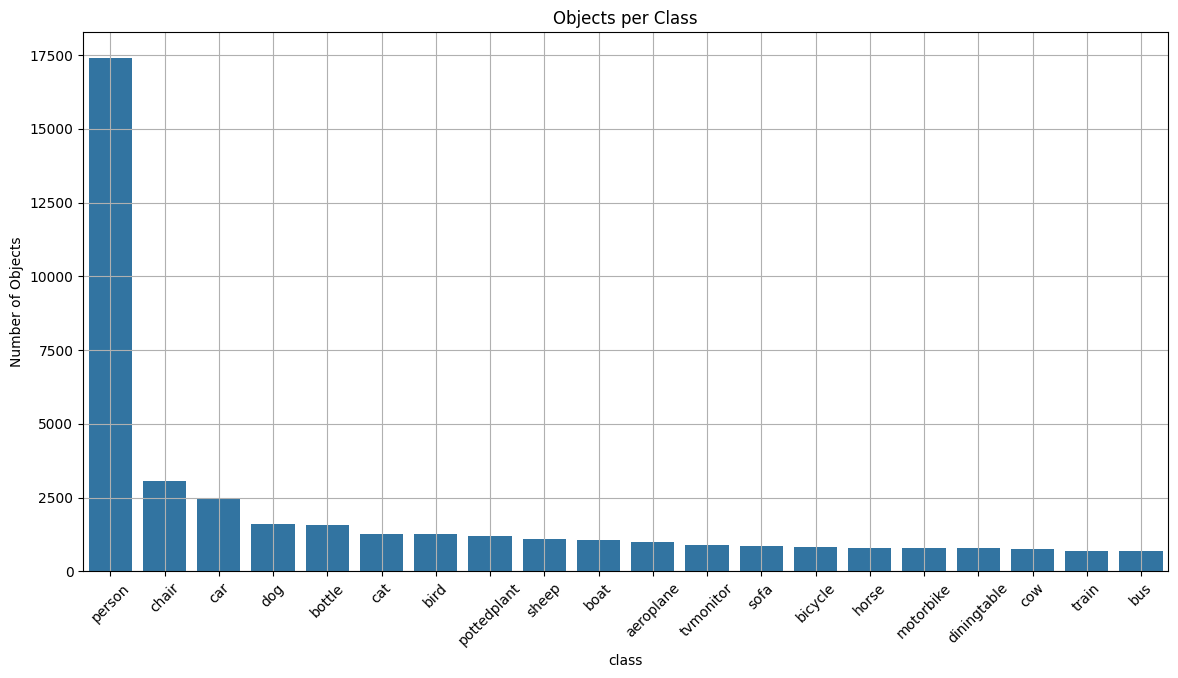

Class imbalance ratio (max/min): 25.40


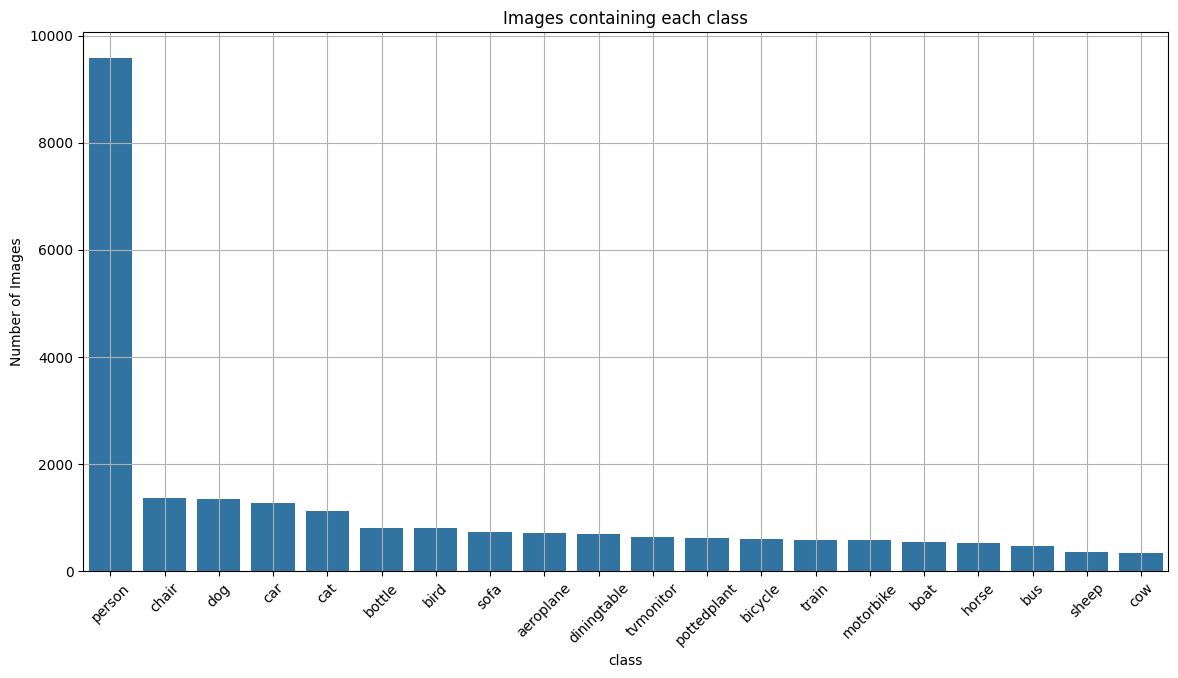

Images with multiple classes: 4889
Images with single class: 12236


In [10]:
# No. of objects per class
classes = df['class'].value_counts()
print("Object counts per class:")
print(classes)

plt.figure(figsize=(14,7))
sns.barplot(x=classes.index, y=classes.values)
plt.title('Objects per Class')
plt.xticks(rotation=45)
plt.ylabel('Number of Objects')
plt.grid(True)
plt.show()

max_class = classes.max()
min_class = classes.min()
imbalance_ratio = max_class / min_class
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

# Images in a class
images_per_class = df.groupby('class')['filename'].nunique().sort_values(ascending=False)
plt.figure(figsize=(14,7))
sns.barplot(x=images_per_class.index, y=images_per_class.values)
plt.title('Images containing each class')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()

image_classes = df.groupby('filename')['class'].nunique()

multi_classes = (image_classes > 1).sum()
single_classes = (image_classes == 1).sum()

print(f"Images with multiple classes: {multi_classes}")
print(f"Images with single class: {single_classes}")


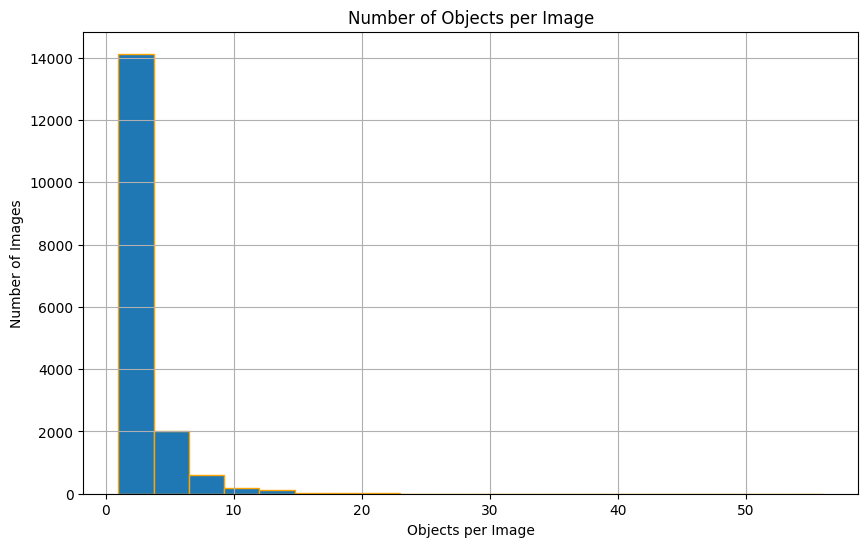

Percentage of images with more than 5 objects: 11.65%


In [12]:
#Objects in a image
obj_img = df.groupby('filename').size()

plt.figure(figsize=(10,6))
plt.hist(obj_img, bins=20, edgecolor='orange')
plt.title('Number of Objects per Image')
plt.xlabel('Objects per Image')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()

#Cumulative distribution
cum = (obj_img >= 5).sum() / len(obj_img)
print(f"Percentage of images with more than 5 objects: {cum*100:.2f}%")

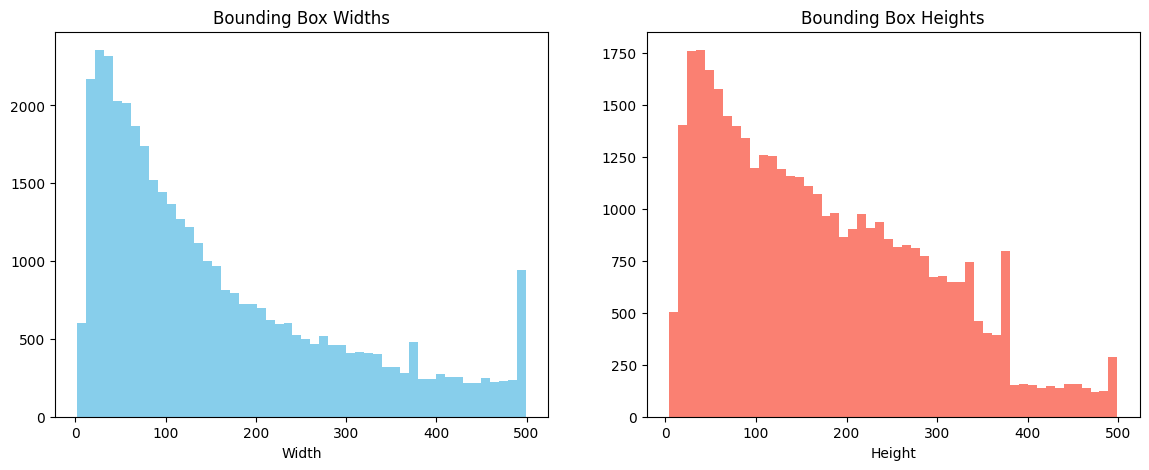

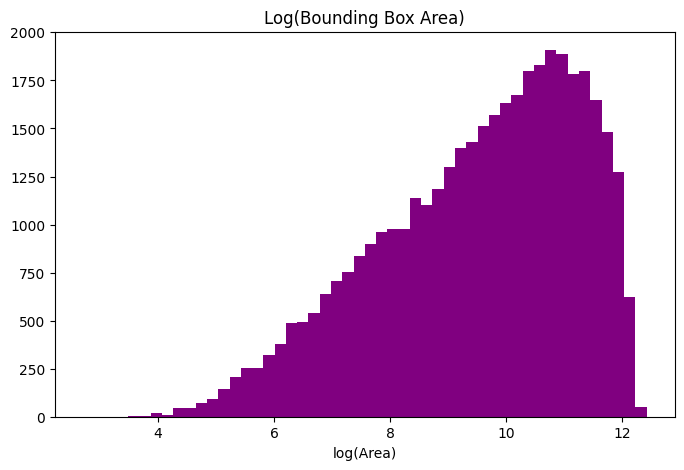

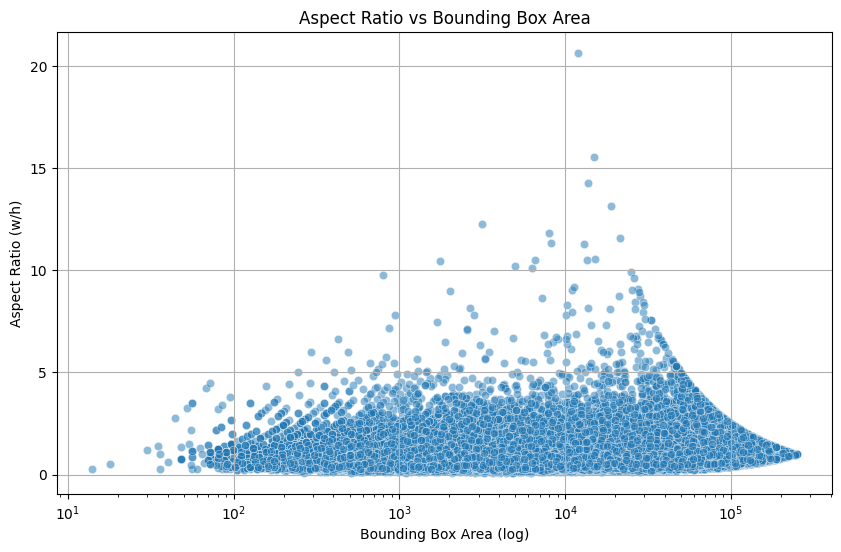

size_bucket
medium    22048
large     12191
small      5899
Name: count, dtype: int64


In [13]:
# --- Absolute bbox sizes ---

df['bbox_width'] = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']
df['bbox_area'] = df['bbox_width'] * df['bbox_height']

# Width and height histograms
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(df['bbox_width'], bins=50, color='skyblue')
plt.title('Bounding Box Widths')
plt.xlabel('Width')

plt.subplot(1,2,2)
plt.hist(df['bbox_height'], bins=50, color='salmon')
plt.title('Bounding Box Heights')
plt.xlabel('Height')
plt.show()

# --- Log area histogram ---
plt.figure(figsize=(8,5))
plt.hist(np.log1p(df['bbox_area']), bins=50, color='purple')
plt.title('Log(Bounding Box Area)')
plt.xlabel('log(Area)')
plt.show()

# --- Aspect ratio ---
df['aspect_ratio'] = df['bbox_width'] / df['bbox_height']

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='bbox_area', y='aspect_ratio', alpha=0.5)
plt.xscale('log')
plt.title('Aspect Ratio vs Bounding Box Area')
plt.xlabel('Bounding Box Area (log)')
plt.ylabel('Aspect Ratio (w/h)')
plt.grid(True)
plt.show()

# --- Relative Size (COCO-style small, medium, large) ---
df['img_area'] = df['width'] * df['height']
df['rel_area'] = df['bbox_area'] / df['img_area']

def size_bucket(rel_area):
    if rel_area < 0.01:
        return 'small'
    elif rel_area < 0.25:
        return 'medium'
    else:
        return 'large'

df['size_bucket'] = df['rel_area'].apply(size_bucket)

print(df['size_bucket'].value_counts())

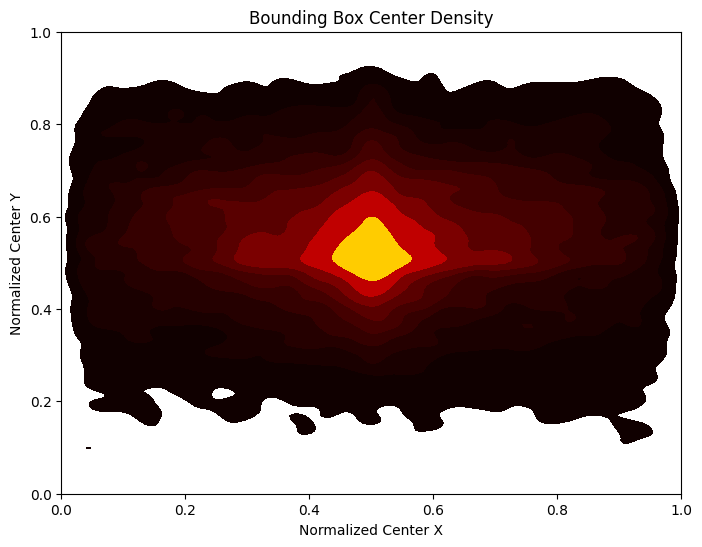

In [14]:
import plotly.express as px
# Center heatmap
df['center_x'] = (df['xmin'] + df['xmax']) / 2 / df['width']
df['center_y'] = (df['ymin'] + df['ymax']) / 2 / df['height']

plt.figure(figsize=(8,6))
sns.kdeplot(x=df['center_x'], y=df['center_y'], cmap='hot', fill=True, bw_adjust=0.5)
plt.title('Bounding Box Center Density')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Normalized Center X')
plt.ylabel('Normalized Center Y')
plt.show()

# Class co-occurrence matrix
from sklearn.preprocessing import MultiLabelBinarizer

# Create a set of classes per image
image_classes = df.groupby('filename')['class'].apply(set)
mlb = MultiLabelBinarizer()
class_matrix = mlb.fit_transform(image_classes)

co_occurrence = np.dot(class_matrix.T, class_matrix)

fig = px.imshow(co_occurrence,
                labels=dict(x="Class", y="Class", color="Co-occurrence"),
                x=mlb.classes_,
                y=mlb.classes_,
                title="Class Co-occurrence Matrix")
fig.show()


In [16]:
import cv2

means = []
stds = []

sample_images = df['filename'].unique()[:300]

for img_name in tqdm(sample_images):
    img_path = os.path.join("/content/VOCdevkit/VOCdevkit/VOC2012/JPEGImages/", img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    means.append(np.mean(img, axis=(0,1)))
    stds.append(np.std(img, axis=(0,1)))

mpc = np.mean(means, axis=0)
std_pc = np.mean(stds, axis=0)

print(f"Mean per channel [R,G,B]: {mpc}")
print(f"Std per channel [R,G,B]: {std_pc}")

100%|██████████| 300/300 [00:08<00:00, 33.79it/s]

Mean per channel [R,G,B]: [116.06663459 111.07777182 102.73109733]
Std per channel [R,G,B]: [61.18207677 59.99750386 61.23305267]


In [17]:
from itertools import combinations
import cv2
# Zero-area boxes
zero_area = df[(df['bbox_width'] <= 0) | (df['bbox_height'] <= 0)]
print(f"Zero-area bounding boxes: {len(zero_area)}")

# Boxes outside image bounds
out_of_bounds = df[
    (df['xmin'] < 0) | (df['ymin'] < 0) |
    (df['xmax'] > df['width']) | (df['ymax'] > df['height'])
]
print(f"Boxes outside image bounds: {len(out_of_bounds)}")

# Highly overlapping boxes (IoU > 0.9)

def iou(box1, box2):
    x1 = max(box1['xmin'], box2['xmin'])
    y1 = max(box1['ymin'], box2['ymin'])
    x2 = min(box1['xmax'], box2['xmax'])
    y2 = min(box1['ymax'], box2['ymax'])

    inter_area = max(0, x2-x1) * max(0, y2-y1)
    area1 = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    area2 = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])

    union = area1 + area2 - inter_area
    if union== 0:
        return 0
    return inter_area / union
iou_pairs = []

for img_name, group in tqdm(df.groupby('filename')):
    boxes = group.to_dict('records')
    for box1, box2 in combinations(boxes, 2):
        if box1['class'] == box2['class']:
            if iou(box1, box2) > 0.9:
                iou_pairs.append((img_name, box1, box2))

print(f"Overlapping same-class boxes: {len(iou_pairs)}")


Zero-area bounding boxes: 0
Boxes outside image bounds: 0


100%|██████████| 17125/17125 [00:23<00:00, 734.39it/s]

Overlapping same-class boxes: 1
